In [1]:
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('dark_background')

$\Large{\text{Fast Fourier Transform (FFT)}}$

$\text{Denoising Data}$

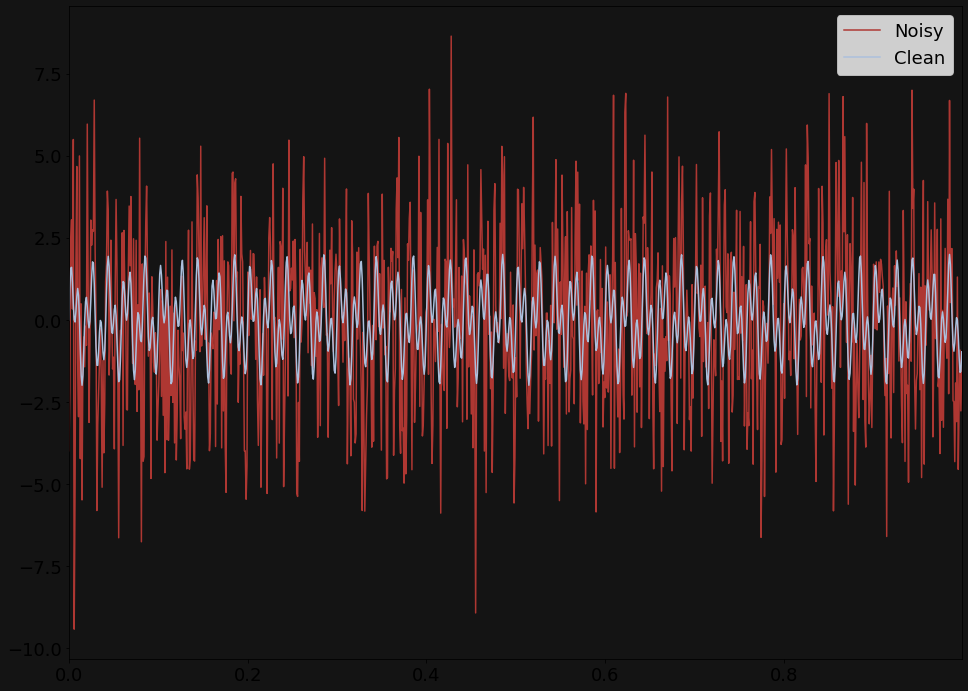

In [2]:
plt.rcParams["figure.figsize"] = [16, 12]
plt.rcParams.update({'font.size': 18})

# Create a simple signal with two frequencies
dt = 0.0009765625
t = np.arange(0, 1, dt)
f = np.sin(100 * np.pi * t) + np.sin(240 * np.pi * t) # Two frequencies
f_clean = f
f = f + 2.5 * np.random.randn(len(t)) # Add noise to data

fig, ax = plt.subplots()
ax.set_facecolor('#141414')
fig.patch.set_facecolor('#141414')

plt.plot(t, f, color='#ae3732', label='Noisy')
plt.plot(t, f_clean, color='#acc0dd', label='Clean')
plt.xlim(t[0], t[-1])
plt.legend()

plt.show()

In [3]:
# Prøver å skrive min egen FFT funksjon
def testFFT(data):
    n = len(data) # n must be a power of 2
    if n == 1:
        return data
    w = np.exp(2 * np.pi * 1j / n)
    even = data[::2]
    odd = data[1::2]
    val_even = testFFT(even)
    val_odd = testFFT(odd)
    vals = [0] * n
    for k in range(n//2):
        vals[k] = val_even[k] + np.power(w, k, dtype=complex) * val_odd[k]
        vals[k + n//2] = val_even[k] - np.power(w, k, dtype=complex) * val_odd[k]
    return vals

1024


C:\Users\morte\AppData\Roaming\Python\Python310\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\morte\AppData\Roaming\Python\Python310\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


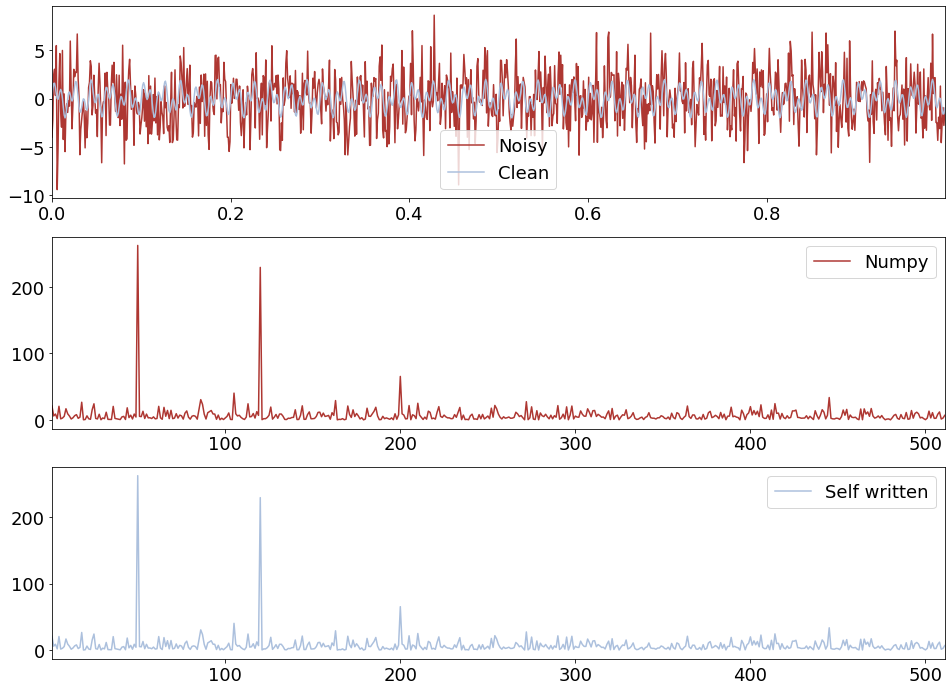

In [4]:
n = len(t)
print(n)
# Numpy functions
fhat = np.fft.fft(f, n)
PSD = fhat * np.conj(fhat) / n

#Self writen functions
fhat_test = testFFT(f)
PSD_test = fhat_test * np.conj(fhat_test) / n

freq = (1/(dt * n)) * np.arange(n)
L = np.arange(1, np.floor(n/2), dtype='int')

fig, axs = plt.subplots(3, 1)

plt.sca(axs[0])
plt.plot(t, f, color='#ae3732', label='Noisy')
plt.plot(t, f_clean, color='#acc0dd', label='Clean')
plt.xlim(t[0], t[-1])
plt.legend()

plt.sca(axs[1])
plt.plot(freq[L], PSD[L], color='#ae3732', label='Numpy')
plt.xlim(freq[L[0]], freq[L[-1]])
plt.legend()

plt.sca(axs[2])
plt.plot(freq[L], PSD_test[L], color='#acc0dd', label='Self written')
plt.xlim(freq[L[0]], freq[L[-1]])
plt.legend()

plt.show()

In [5]:
# Use the PSD to filter out noise
indices = PSD > 100        # Find all freqs with large power
PSDclean = PSD * indices   # Zero out all others
fhat = indices * fhat      # Zero out all small coeffs
ffilt = np.fft.ifft(fhat)  # Inverse FFT for filtered signal

C:\Users\morte\AppData\Roaming\Python\Python310\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\morte\AppData\Roaming\Python\Python310\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\morte\AppData\Roaming\Python\Python310\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


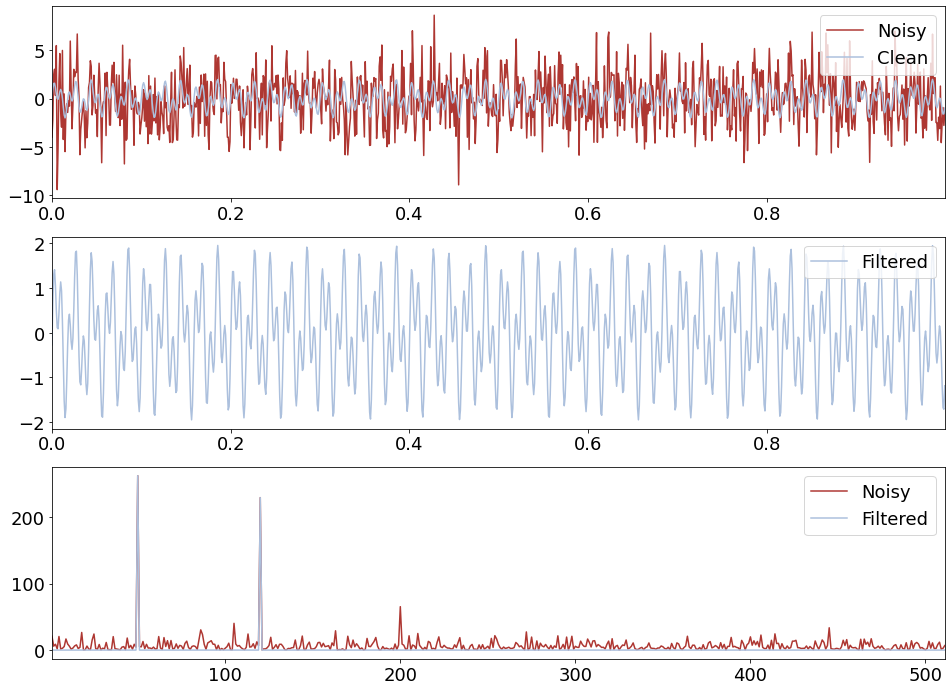

In [6]:
fig, axis = plt.subplots(3, 1)

plt.sca(axis[0])
plt.plot(t, f, color='#ae3732', label='Noisy')
plt.plot(t, f_clean, color='#acc0dd', label='Clean')
plt.xlim(t[0], t[-1])
plt.legend(loc="upper right")

plt.sca(axis[1])
plt.plot(t, ffilt, color='#acc0dd', label='Filtered')
plt.xlim(t[0], t[-1])
plt.legend(loc="upper right")

plt.sca(axis[2])
plt.plot(freq[L], PSD[L], color='#ae3732', label='Noisy')
plt.plot(freq[L], PSDclean[L], color='#acc0dd', label='Filtered')
plt.xlim(freq[L[0]], freq[L[-1]])
plt.legend(loc="upper right")

plt.show()

$\text{Solving PDEs}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import axes3d
import matplotlib.cm as cm
plt.rcParams["figure.figsize"] = [20,20]
plt.rcParams.update({'font.size': 18})
# plt.style.use('dark_background')

In [2]:
a = 1    # Thermal diffusivity constant
L = 100  # Length of domain
N = 1000 # Number of discretization points
dx = L/N
x = np.arange(-L/2, L/2, dx) # Define x domain

In [3]:
# Define discrete wavenumbers
kappa = 2 * np.pi * np.fft.fftfreq(N, d=dx)

# Initial condition
u0 = np.zeros_like(x)
u0[int((L/2 - L/10)/dx):int((L/2 + L/10)/dx)] = 1
u0hat = np.fft.fft(u0)

# SciPy's odeint function doesn't play well with complex numbers, so we
# make it a 2N-element vector of real values
u0hat_ri = np.concatenate((u0hat.real, u0hat.imag))

In [4]:
# Simulate in Fourier frequency domain
dt = 0.1
t = np.arange(0, 50, dt)

def rhsHeat(uhat_ri, t, kappa, a):
    uhat = uhat_ri[:N] + 1j * uhat_ri[N:]
    d_uhat = -a**2 * np.power(kappa, 2) * uhat
    d_uhat_ri = np.concatenate((d_uhat.real, d_uhat.imag)).astype('float64')
    return d_uhat_ri

uhat_ri = odeint(rhsHeat, u0hat_ri, t, args=(kappa, a))

uhat = uhat_ri[:, :N] + 1j * uhat_ri[:, N:]

u = np.zeros_like(uhat)

for k in range(len(t)):
    u[k,:] = np.fft.ifft(uhat[k, :])

u = u.real

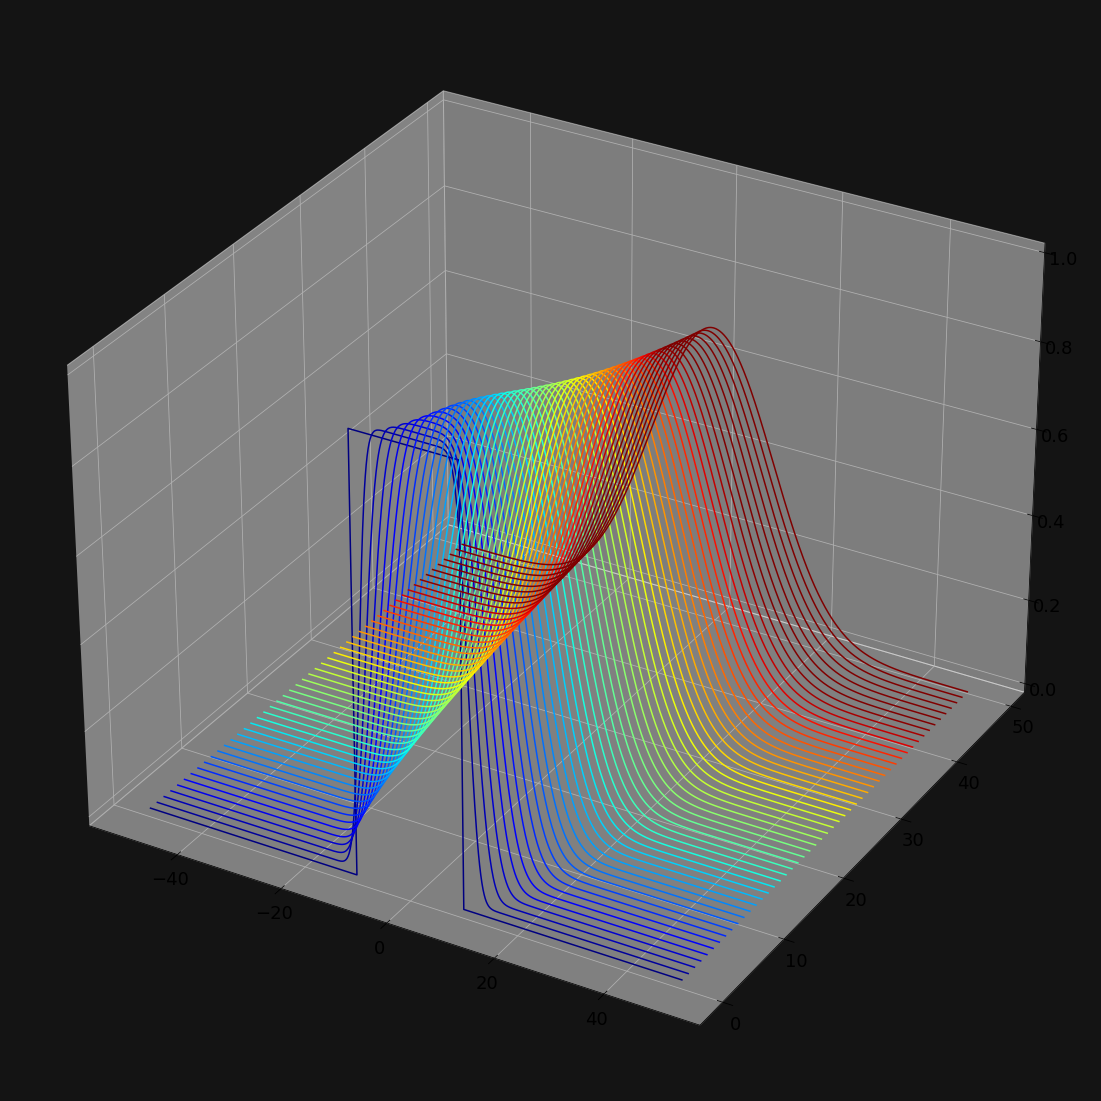

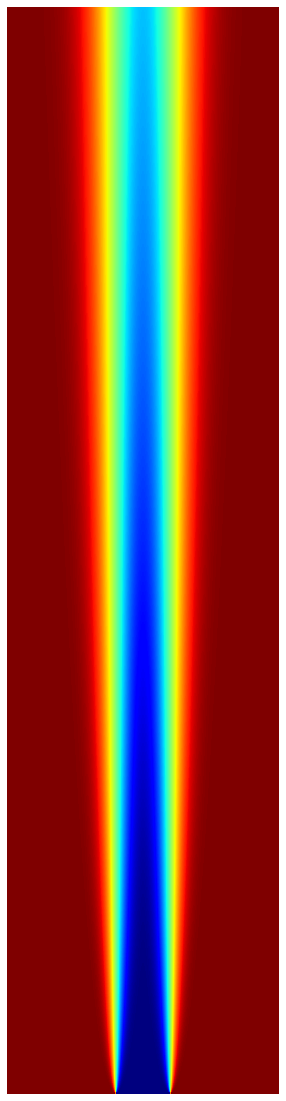

In [5]:
# Waterfall plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('#141414')
fig.patch.set_facecolor('#141414')
plt.set_cmap('jet_r')
u_plot = u[0:-1:10,:]
for j in range(u_plot.shape[0]):
    ys = j * np.ones(u_plot.shape[1])
    ax.plot(x, ys, u_plot[j,:], color=cm.jet(j*6))

# Image plot
plt.figure()
plt.imshow(np.flipud(u), aspect=8)
plt.axis('off')
plt.set_cmap('jet_r')
plt.show()

$\text{Spectogram}$

In [6]:
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams.update({"font.size": 18})

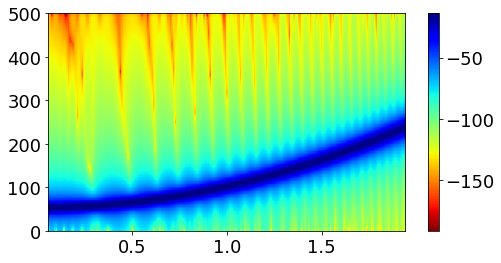

In [7]:
dt = 0.001
t = np.arange(0, 2, dt)
f0 = 50
f1 = 250
f2 = 2
t1 = 2
x = np.cos(2 * np.pi * t * (f0 + (f1 - f0) * np.power(t, 2)/(3 * t1**2)))

fs = 1/dt
sd.play(2*x, fs)

plt.specgram(x, NFFT=128, Fs=1/dt, noverlap=120, cmap='jet_r')
plt.colorbar()
plt.show()

In [8]:
import librosa
y, sr = librosa.load('./files/calm.mp3')

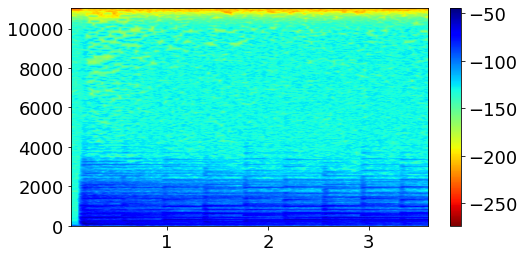

In [9]:
plt.figure()
plt.specgram(y[20000:100000], NFFT=2048, Fs=sr, noverlap=2000, cmap='jet_r')
plt.colorbar()
plt.show()

In [10]:
sd.play(y[20000:500000], sr)

$\text{Image Compression}$

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams.update({"font.size": 18})

(-0.5, 999.5, 1193.5, -0.5)

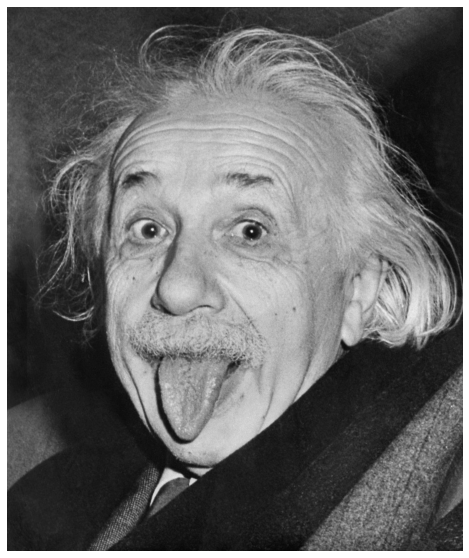

In [11]:
A = imread('./files/albert_einstein.jpg')
B = np.mean(A, -1) # Convert RGB to grayscale

plt.figure()
plt.imshow(A, cmap='Greys')
plt.axis('off')

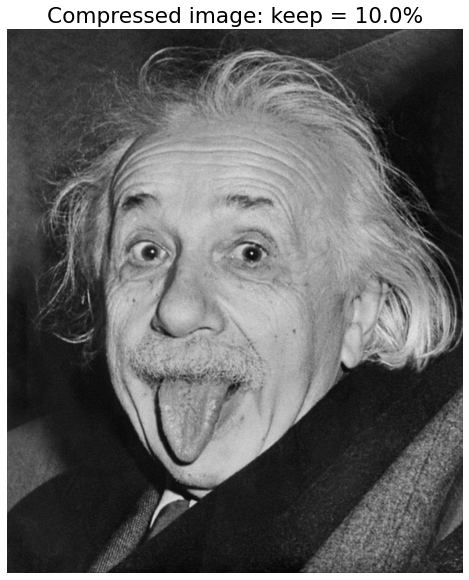

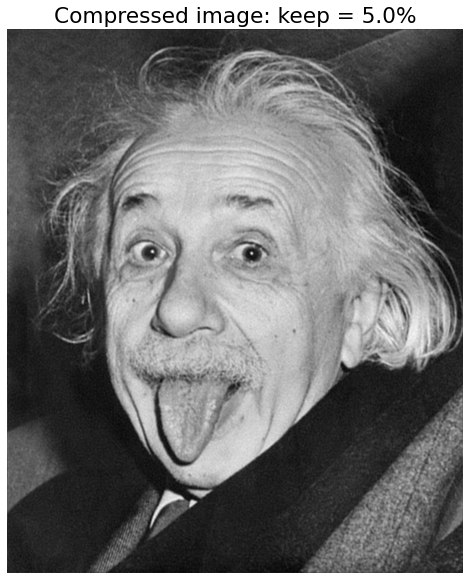

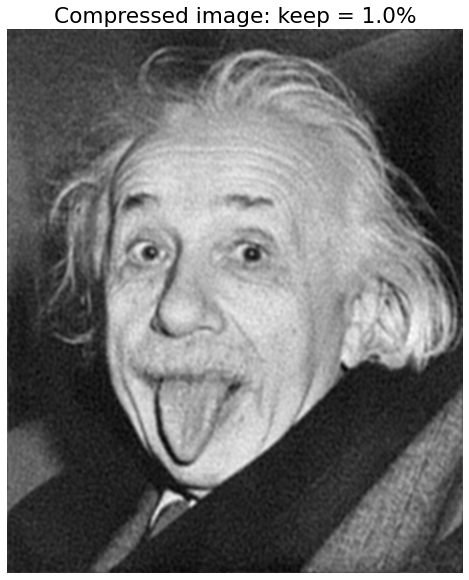

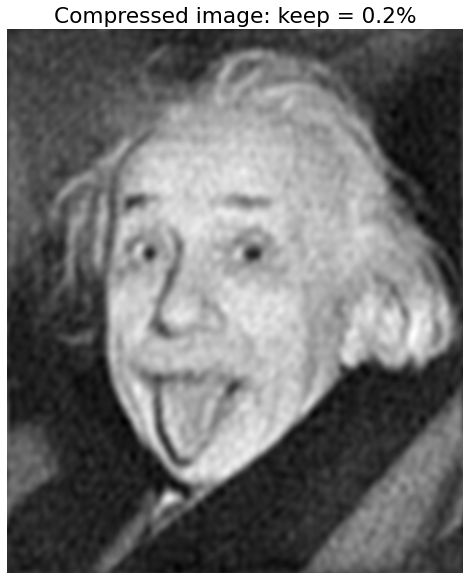

In [12]:
Bt = np.fft.fft2(B)
Btsort = np.sort(np.abs(Bt.reshape(-1))) # Sort by magnitude

# Zero out all small coefficients and inverse transform
for keep in (0.1, 0.05, 0.01, 0.002):
    thresh = Btsort[int(np.floor((1 - keep) * len(Btsort)))]
    ind = np.abs(Bt) > thresh           # Find all small indices
    Btlow = Bt * ind                    # Threshold small indices
    Alow = np.fft.ifft2(Btlow).real     # Compressed image
    plt.figure()
    plt.imshow(Alow, cmap='gray')
    plt.axis('off')
    plt.title('Compressed image: keep = ' + str(keep * 100) + "%")

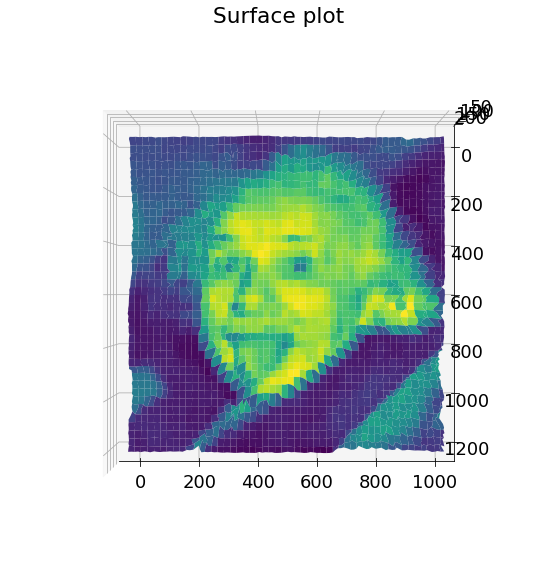

In [34]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(1, np.shape(B)[1] + 1), np.arange(1, np.shape(B)[0] + 1))
ax.plot_surface(X[0::10, 0::10], Y[0::10, 0::10], B[0::10, 0::10], cmap='viridis', edgecolor='none')
ax.set_title('Surface plot')
ax.view_init(270, 270) # 630, 270
plt.show()